In [1]:
import random
import pandas as pd
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dropout, Dense
import keras as k
import keras.backend as K
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import keras

In [2]:
# Read the Data
#df = pd.read_csv('../../data/original.csv',  index_col=0)
df = pd.read_csv('../../data/mcar_10.csv',  index_col=0)
original = pd.read_csv('../../data/original.csv',  index_col=0)
gene_info = pd.read_csv('../../data/gene_info.csv',  index_col=0)

In [3]:
param = np.array(gene_info['param'])

X = np.array(df.T)  
n_dims = X.shape[1]
original = original.T

means = original.mean(axis = 1)
means = [0 if x < means.mean() else 1 for x in means]

latent_dim = 2

In [ ]:
X

In [4]:
def masked_mae(X_true, X_pred, mask):
    masked_diff = X_true[mask] - X_pred[mask]
    return np.mean(np.abs(masked_diff))


def fill(self, missing_mask):
  self.data[missing_mask] = -1


def create_missing_mask(X):
  if X.dtype != "f" and X.dtype != "d":
      X = X.astype(float)
  return np.isnan(X.data)


def bool_to_binary(matrix):

  binary_matrix = []
  for row in matrix:
      binary_row = []
      for value in row:
          binary_row.append(1 if value else 0)
      binary_matrix.append(binary_row)
  return binary_matrix


def replace_nan(data, replacement):


  if not isinstance(data, np.ndarray):
      raise ValueError("Unsupported data type. Function supports numpy arrays only.")

  data[np.isnan(data)] = replacement

  return data


In [5]:
mask = np.array(bool_to_binary(create_missing_mask(X)))
X_no_na = replace_nan(X, replacement = 1)
input_with_mask = np.hstack([X_no_na, mask])


In [6]:
def reconstruction(input_and_mask, y_pred):
    input_and_mask = input_and_mask
    X_values = input_and_mask[:, :n_dims]

    missing_mask = input_and_mask[:, n_dims:]

    observed_mask = 1 - missing_mask

    X_values_observed = X_values * observed_mask

    pred_observed = y_pred * observed_mask
    
    mse = K.sum(K.square(pred_observed - X_values_observed) * K.cast(K.not_equal(X_values_observed, 0), K.floatx())) / K.maximum(K.sum(K.cast(K.not_equal(X_values_observed, 0), K.floatx())), 1)
    #mse = K.mean(K.square(X_values_observed * K.cast(K.not_equal(X_values_observed, 0), K.floatx()) - pred_observed), axis=-1)


    return mse

In [7]:
# This are the dimensions of the original input, the intermediate layer and latent layer
original_dim = n_dims
latent_dim = 2 # 

def sampling(args):
    # reparameterization trick
    # instead of sampling from Q(z|x), sample eps = N(0,I)
    # then x = x_mean + x_sigma*eps= x_mean + sqrt(e^(x_log_var))*eps = x_mean + e^(0.5 * x_log_var)*eps
    x_mean, x_log_var = args
    epsilon = K.random_normal(shape=(K.shape(x_mean)[0], latent_dim), mean=0.,
                              stddev=1.0)
    return x_mean + K.exp(0.5 * x_log_var) * epsilon

In [8]:
K.clear_session()

# Variational autoencoder model
input_img = keras.layers.Input(shape=(2*original_dim,))
encoded = keras.layers.Dense(64)(input_img)
encoded = keras.layers.Dense(16)(encoded)
x_mean = keras.layers.Dense(latent_dim)(encoded)
x_log_var = keras.layers.Dense(latent_dim)(encoded) # implementation choice to encode the log variance i.s.o. the standard deviation

x = k.layers.Lambda(sampling, output_shape=(latent_dim,))([x_mean, x_log_var])
# at this point the representation has dimension: latent_dim 

decoded = keras.layers.Dense(16)(x)
decoded = keras.layers.Dense(64)(decoded)
decoded = keras.layers.Dense(original_dim, activation='linear')(decoded)
vae = keras.Model(input_img, decoded, name='vae')
#print (vae.summary())

# Create the loss function and compile the model
# The loss function as defined by paper Kingma

reconstruction_loss = original_dim * reconstruction(input_img, decoded)  
kl_loss =  -0.5 * K.sum(1 + x_log_var - K.square(x_mean) -K.exp(x_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Next the encoder part and decoder model, in order to inspect the inner representation, referencing the autoencode layers (the 3 models share there weights)
# This part can be ommitted in case you don't want to use the inner latent representation 

# encoder model (first part of the variotional autoencoder) 
encoder = keras.Model(input_img, [x_mean, x_log_var, x], name='encoder')
#print (encoder.summary())

# decoder model (second part of the autoencoder) to be able to generate an image from an inner representation
encoded_input = keras.Input(shape=(latent_dim,))
decoder_layer = vae.layers[-2](encoded_input) # Retrieve the last layers of the autoencoder model
decoder_layer = vae.layers[-1](decoder_layer)
decoder = keras.Model(encoded_input, decoder_layer, name='decoder')
#print (decoder.summary())

2023-04-12 13:58:58.275387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
keras.utils.plot_model(encoder, to_file='model.png', show_shapes=True)

In [9]:
vae.fit(input_with_mask,input_with_mask,
        shuffle=True,
        epochs=3000,
        batch_size=32,
        #validation_split= 0.2,
        #callbacks=[early_stop]
       )

Epoch 1/3000
10/10 [==============================] - 0s 1ms/step - loss: 531926253568.0000
Epoch 2/3000
10/10 [==============================] - 0s 1ms/step - loss: 3951.2000
Epoch 3/3000
10/10 [==============================] - 0s 1ms/step - loss: 3890.0149
Epoch 4/3000
10/10 [==============================] - 0s 1ms/step - loss: 3948.3289
Epoch 5/3000
10/10 [==============================] - 0s 1ms/step - loss: 4134.8931
Epoch 6/3000
10/10 [==============================] - 0s 1ms/step - loss: 4029.2534
Epoch 7/3000
10/10 [==============================] - 0s 1ms/step - loss: 3997.2466
Epoch 8/3000
10/10 [==============================] - 0s 1ms/step - loss: 3944.8931
Epoch 9/3000
10/10 [==============================] - 0s 1ms/step - loss: 3993.2495
Epoch 10/3000
10/10 [==============================] - 0s 1ms/step - loss: 3958.2612
Epoch 11/3000
10/10 [==============================] - 0s 1ms/step - loss: 3941.7820
Epoch 12/3000
10/10 [==============================] - 0s 1ms/step

10/10 [==============================] - 0s 1ms/step - loss: 3779.3359
Epoch 98/3000
10/10 [==============================] - 0s 1ms/step - loss: 3749.0422
Epoch 99/3000
10/10 [==============================] - 0s 1ms/step - loss: 3734.1184
Epoch 100/3000
10/10 [==============================] - 0s 1ms/step - loss: 3863.2527
Epoch 101/3000
10/10 [==============================] - 0s 1ms/step - loss: 3792.5789
Epoch 102/3000
10/10 [==============================] - 0s 1ms/step - loss: 3789.7769
Epoch 103/3000
10/10 [==============================] - 0s 1ms/step - loss: 3808.8228
Epoch 104/3000
10/10 [==============================] - 0s 1ms/step - loss: 3903.4187
Epoch 105/3000
10/10 [==============================] - 0s 1ms/step - loss: 3870.9976
Epoch 106/3000
10/10 [==============================] - 0s 1ms/step - loss: 3793.9214
Epoch 107/3000
10/10 [==============================] - 0s 1ms/step - loss: 3827.6147
Epoch 108/3000
10/10 [==============================] - 0s 1ms/step - l

10/10 [==============================] - 0s 1ms/step - loss: 3613.7195
Epoch 193/3000
10/10 [==============================] - 0s 1ms/step - loss: 3758.8997
Epoch 194/3000
10/10 [==============================] - 0s 1ms/step - loss: 3705.7231
Epoch 195/3000
10/10 [==============================] - 0s 1ms/step - loss: 3586.6152
Epoch 196/3000
10/10 [==============================] - 0s 1ms/step - loss: 3750.0962
Epoch 197/3000
10/10 [==============================] - 0s 1ms/step - loss: 3697.7336
Epoch 198/3000
10/10 [==============================] - 0s 1ms/step - loss: 3719.4758
Epoch 199/3000
10/10 [==============================] - 0s 1ms/step - loss: 3660.7520
Epoch 200/3000
10/10 [==============================] - 0s 1ms/step - loss: 3723.5422
Epoch 201/3000
10/10 [==============================] - 0s 1ms/step - loss: 3613.3606
Epoch 202/3000
10/10 [==============================] - 0s 1ms/step - loss: 3641.4641
Epoch 203/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 3549.0020
Epoch 288/3000
10/10 [==============================] - 0s 1ms/step - loss: 3530.5852
Epoch 289/3000
10/10 [==============================] - 0s 1ms/step - loss: 3516.5925
Epoch 290/3000
10/10 [==============================] - 0s 1ms/step - loss: 3583.1997
Epoch 291/3000
10/10 [==============================] - 0s 1ms/step - loss: 3572.1145
Epoch 292/3000
10/10 [==============================] - 0s 1ms/step - loss: 3495.9578
Epoch 293/3000
10/10 [==============================] - 0s 1ms/step - loss: 3520.5269
Epoch 294/3000
10/10 [==============================] - 0s 1ms/step - loss: 3494.0503
Epoch 295/3000
10/10 [==============================] - 0s 1ms/step - loss: 3588.8696
Epoch 296/3000
10/10 [==============================] - 0s 1ms/step - loss: 3497.4114
Epoch 297/3000
10/10 [==============================] - 0s 1ms/step - loss: 3555.0469
Epoch 298/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 3366.6587
Epoch 383/3000
10/10 [==============================] - 0s 1ms/step - loss: 3341.5911
Epoch 384/3000
10/10 [==============================] - 0s 1ms/step - loss: 3344.6125
Epoch 385/3000
10/10 [==============================] - 0s 1ms/step - loss: 3338.9399
Epoch 386/3000
10/10 [==============================] - 0s 1ms/step - loss: 3400.6394
Epoch 387/3000
10/10 [==============================] - 0s 1ms/step - loss: 3328.6108
Epoch 388/3000
10/10 [==============================] - 0s 1ms/step - loss: 3346.6223
Epoch 389/3000
10/10 [==============================] - 0s 1ms/step - loss: 3307.7007
Epoch 390/3000
10/10 [==============================] - 0s 1ms/step - loss: 3335.7590
Epoch 391/3000
10/10 [==============================] - 0s 1ms/step - loss: 3292.7070
Epoch 392/3000
10/10 [==============================] - 0s 1ms/step - loss: 3292.4263
Epoch 393/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 3102.6272
Epoch 478/3000
10/10 [==============================] - 0s 1ms/step - loss: 3171.9126
Epoch 479/3000
10/10 [==============================] - 0s 1ms/step - loss: 3072.4995
Epoch 480/3000
10/10 [==============================] - 0s 1ms/step - loss: 3057.8459
Epoch 481/3000
10/10 [==============================] - 0s 1ms/step - loss: 3151.8706
Epoch 482/3000
10/10 [==============================] - 0s 1ms/step - loss: 3052.8384
Epoch 483/3000
10/10 [==============================] - 0s 1ms/step - loss: 3150.6765
Epoch 484/3000
10/10 [==============================] - 0s 1ms/step - loss: 3061.7395
Epoch 485/3000
10/10 [==============================] - 0s 1ms/step - loss: 3044.6821
Epoch 486/3000
10/10 [==============================] - 0s 1ms/step - loss: 3049.4958
Epoch 487/3000
10/10 [==============================] - 0s 1ms/step - loss: 3155.3479
Epoch 488/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 2819.1421
Epoch 573/3000
10/10 [==============================] - 0s 1ms/step - loss: 2830.1001
Epoch 574/3000
10/10 [==============================] - 0s 1ms/step - loss: 2825.9656
Epoch 575/3000
10/10 [==============================] - 0s 1ms/step - loss: 2836.9858
Epoch 576/3000
10/10 [==============================] - 0s 1ms/step - loss: 2888.0471
Epoch 577/3000
10/10 [==============================] - 0s 1ms/step - loss: 2795.9600
Epoch 578/3000
10/10 [==============================] - 0s 1ms/step - loss: 2829.0979
Epoch 579/3000
10/10 [==============================] - 0s 1ms/step - loss: 2831.5647
Epoch 580/3000
10/10 [==============================] - 0s 1ms/step - loss: 2738.8503
Epoch 581/3000
10/10 [==============================] - 0s 1ms/step - loss: 2769.5618
Epoch 582/3000
10/10 [==============================] - 0s 1ms/step - loss: 2703.3479
Epoch 583/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 2522.0339
Epoch 668/3000
10/10 [==============================] - 0s 1ms/step - loss: 2481.0386
Epoch 669/3000
10/10 [==============================] - 0s 1ms/step - loss: 2532.7126
Epoch 670/3000
10/10 [==============================] - 0s 1ms/step - loss: 2559.6018
Epoch 671/3000
10/10 [==============================] - 0s 1ms/step - loss: 2484.7642
Epoch 672/3000
10/10 [==============================] - 0s 1ms/step - loss: 2413.9434
Epoch 673/3000
10/10 [==============================] - 0s 1ms/step - loss: 2513.5842
Epoch 674/3000
10/10 [==============================] - 0s 1ms/step - loss: 2445.0913
Epoch 675/3000
10/10 [==============================] - 0s 1ms/step - loss: 2535.5886
Epoch 676/3000
10/10 [==============================] - 0s 1ms/step - loss: 2400.7136
Epoch 677/3000
10/10 [==============================] - 0s 1ms/step - loss: 2485.4985
Epoch 678/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 2114.7180
Epoch 763/3000
10/10 [==============================] - 0s 1ms/step - loss: 2113.9751
Epoch 764/3000
10/10 [==============================] - 0s 1ms/step - loss: 2163.0923
Epoch 765/3000
10/10 [==============================] - 0s 1ms/step - loss: 2086.7136
Epoch 766/3000
10/10 [==============================] - 0s 1ms/step - loss: 2092.9546
Epoch 767/3000
10/10 [==============================] - 0s 1ms/step - loss: 2103.5818
Epoch 768/3000
10/10 [==============================] - 0s 1ms/step - loss: 2099.6138
Epoch 769/3000
10/10 [==============================] - 0s 1ms/step - loss: 2084.4463
Epoch 770/3000
10/10 [==============================] - 0s 1ms/step - loss: 2058.9727
Epoch 771/3000
10/10 [==============================] - 0s 1ms/step - loss: 2066.2314
Epoch 772/3000
10/10 [==============================] - 0s 1ms/step - loss: 2140.6514
Epoch 773/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 1755.3044
Epoch 858/3000
10/10 [==============================] - 0s 1ms/step - loss: 1741.3469
Epoch 859/3000
10/10 [==============================] - 0s 1ms/step - loss: 1741.1826
Epoch 860/3000
10/10 [==============================] - 0s 997us/step - loss: 1733.9851
Epoch 861/3000
10/10 [==============================] - 0s 1ms/step - loss: 1758.7750
Epoch 862/3000
10/10 [==============================] - 0s 1ms/step - loss: 1749.6998
Epoch 863/3000
10/10 [==============================] - 0s 1ms/step - loss: 1744.0559
Epoch 864/3000
10/10 [==============================] - 0s 1ms/step - loss: 1745.6096
Epoch 865/3000
10/10 [==============================] - 0s 1ms/step - loss: 1768.9568
Epoch 866/3000
10/10 [==============================] - 0s 1ms/step - loss: 1766.1575
Epoch 867/3000
10/10 [==============================] - 0s 1ms/step - loss: 1706.1689
Epoch 868/3000
10/10 [==============================] - 0s 1ms/step

10/10 [==============================] - 0s 1ms/step - loss: 1381.3691
Epoch 953/3000
10/10 [==============================] - 0s 1ms/step - loss: 1413.0690
Epoch 954/3000
10/10 [==============================] - 0s 1ms/step - loss: 1386.9749
Epoch 955/3000
10/10 [==============================] - 0s 1ms/step - loss: 1377.4729
Epoch 956/3000
10/10 [==============================] - 0s 1ms/step - loss: 1437.1606
Epoch 957/3000
10/10 [==============================] - 0s 1ms/step - loss: 1388.3962
Epoch 958/3000
10/10 [==============================] - 0s 1ms/step - loss: 1415.5281
Epoch 959/3000
10/10 [==============================] - 0s 1ms/step - loss: 1387.8899
Epoch 960/3000
10/10 [==============================] - 0s 1ms/step - loss: 1355.3898
Epoch 961/3000
10/10 [==============================] - 0s 1ms/step - loss: 1391.1843
Epoch 962/3000
10/10 [==============================] - 0s 1ms/step - loss: 1348.0681
Epoch 963/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 1159.7933
Epoch 1047/3000
10/10 [==============================] - 0s 1ms/step - loss: 1143.4651
Epoch 1048/3000
10/10 [==============================] - 0s 1ms/step - loss: 1117.4132
Epoch 1049/3000
10/10 [==============================] - 0s 1ms/step - loss: 1137.6620
Epoch 1050/3000
10/10 [==============================] - 0s 1ms/step - loss: 1082.2374
Epoch 1051/3000
10/10 [==============================] - 0s 1ms/step - loss: 1130.5811
Epoch 1052/3000
10/10 [==============================] - 0s 1ms/step - loss: 1100.6692
Epoch 1053/3000
10/10 [==============================] - 0s 1ms/step - loss: 1088.3352
Epoch 1054/3000
10/10 [==============================] - 0s 1ms/step - loss: 1060.2356
Epoch 1055/3000
10/10 [==============================] - 0s 1ms/step - loss: 1101.0227
Epoch 1056/3000
10/10 [==============================] - 0s 1ms/step - loss: 1051.1265
Epoch 1057/3000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 1ms/step - loss: 862.1984
Epoch 1141/3000
10/10 [==============================] - 0s 1ms/step - loss: 882.0807
Epoch 1142/3000
10/10 [==============================] - 0s 1ms/step - loss: 880.4099
Epoch 1143/3000
10/10 [==============================] - 0s 1ms/step - loss: 862.0751
Epoch 1144/3000
10/10 [==============================] - 0s 1ms/step - loss: 856.2538
Epoch 1145/3000
10/10 [==============================] - 0s 1ms/step - loss: 854.4539
Epoch 1146/3000
10/10 [==============================] - 0s 1ms/step - loss: 875.0687
Epoch 1147/3000
10/10 [==============================] - 0s 1ms/step - loss: 841.8513
Epoch 1148/3000
10/10 [==============================] - 0s 1ms/step - loss: 872.1740
Epoch 1149/3000
10/10 [==============================] - 0s 1ms/step - loss: 884.2802
Epoch 1150/3000
10/10 [==============================] - 0s 1ms/step - loss: 863.8657
Epoch 1151/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 708.7751
Epoch 1236/3000
10/10 [==============================] - 0s 1ms/step - loss: 710.1255
Epoch 1237/3000
10/10 [==============================] - 0s 1ms/step - loss: 705.9661
Epoch 1238/3000
10/10 [==============================] - 0s 1ms/step - loss: 706.4961
Epoch 1239/3000
10/10 [==============================] - 0s 1ms/step - loss: 727.7939
Epoch 1240/3000
10/10 [==============================] - 0s 1ms/step - loss: 696.6718
Epoch 1241/3000
10/10 [==============================] - 0s 1ms/step - loss: 706.1199
Epoch 1242/3000
10/10 [==============================] - 0s 1ms/step - loss: 716.4259
Epoch 1243/3000
10/10 [==============================] - 0s 1ms/step - loss: 697.4373
Epoch 1244/3000
10/10 [==============================] - 0s 1ms/step - loss: 739.3325
Epoch 1245/3000
10/10 [==============================] - 0s 1ms/step - loss: 724.2957
Epoch 1246/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 638.4310
Epoch 1331/3000
10/10 [==============================] - 0s 1ms/step - loss: 618.0521
Epoch 1332/3000
10/10 [==============================] - 0s 1ms/step - loss: 635.9762
Epoch 1333/3000
10/10 [==============================] - 0s 1ms/step - loss: 614.7347
Epoch 1334/3000
10/10 [==============================] - 0s 1ms/step - loss: 613.9347
Epoch 1335/3000
10/10 [==============================] - 0s 1ms/step - loss: 603.4174
Epoch 1336/3000
10/10 [==============================] - 0s 1ms/step - loss: 620.1238
Epoch 1337/3000
10/10 [==============================] - 0s 1ms/step - loss: 638.5046
Epoch 1338/3000
10/10 [==============================] - 0s 1ms/step - loss: 613.1458
Epoch 1339/3000
10/10 [==============================] - 0s 1ms/step - loss: 607.7965
Epoch 1340/3000
10/10 [==============================] - 0s 1ms/step - loss: 610.3335
Epoch 1341/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 569.3234
Epoch 1426/3000
10/10 [==============================] - 0s 1ms/step - loss: 576.8779
Epoch 1427/3000
10/10 [==============================] - 0s 1ms/step - loss: 548.0524
Epoch 1428/3000
10/10 [==============================] - 0s 1ms/step - loss: 610.6689
Epoch 1429/3000
10/10 [==============================] - 0s 1ms/step - loss: 568.3074
Epoch 1430/3000
10/10 [==============================] - 0s 1ms/step - loss: 601.1957
Epoch 1431/3000
10/10 [==============================] - 0s 1ms/step - loss: 564.4899
Epoch 1432/3000
10/10 [==============================] - 0s 1ms/step - loss: 570.0233
Epoch 1433/3000
10/10 [==============================] - 0s 1ms/step - loss: 584.4673
Epoch 1434/3000
10/10 [==============================] - 0s 1ms/step - loss: 575.8648
Epoch 1435/3000
10/10 [==============================] - 0s 1ms/step - loss: 565.6798
Epoch 1436/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 551.6200
Epoch 1521/3000
10/10 [==============================] - 0s 1ms/step - loss: 541.3380
Epoch 1522/3000
10/10 [==============================] - 0s 1ms/step - loss: 552.8997
Epoch 1523/3000
10/10 [==============================] - 0s 1ms/step - loss: 546.3957
Epoch 1524/3000
10/10 [==============================] - 0s 1ms/step - loss: 539.7777
Epoch 1525/3000
10/10 [==============================] - 0s 1ms/step - loss: 580.0659
Epoch 1526/3000
10/10 [==============================] - 0s 1ms/step - loss: 586.7845
Epoch 1527/3000
10/10 [==============================] - 0s 1ms/step - loss: 547.5231
Epoch 1528/3000
10/10 [==============================] - 0s 1ms/step - loss: 543.2125
Epoch 1529/3000
10/10 [==============================] - 0s 1ms/step - loss: 560.6764
Epoch 1530/3000
10/10 [==============================] - 0s 1ms/step - loss: 562.7373
Epoch 1531/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 588.7180
Epoch 1616/3000
10/10 [==============================] - 0s 1ms/step - loss: 543.9879
Epoch 1617/3000
10/10 [==============================] - 0s 1ms/step - loss: 544.7131
Epoch 1618/3000
10/10 [==============================] - 0s 1ms/step - loss: 536.1996
Epoch 1619/3000
10/10 [==============================] - 0s 1ms/step - loss: 544.4316
Epoch 1620/3000
10/10 [==============================] - 0s 1ms/step - loss: 550.6469
Epoch 1621/3000
10/10 [==============================] - 0s 1ms/step - loss: 534.3385
Epoch 1622/3000
10/10 [==============================] - 0s 1ms/step - loss: 538.3739
Epoch 1623/3000
10/10 [==============================] - 0s 1ms/step - loss: 543.8936
Epoch 1624/3000
10/10 [==============================] - 0s 1ms/step - loss: 531.9814
Epoch 1625/3000
10/10 [==============================] - 0s 1ms/step - loss: 550.5640
Epoch 1626/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 563.6287
Epoch 1711/3000
10/10 [==============================] - 0s 1ms/step - loss: 526.3817
Epoch 1712/3000
10/10 [==============================] - 0s 1ms/step - loss: 563.0253
Epoch 1713/3000
10/10 [==============================] - 0s 1ms/step - loss: 557.1327
Epoch 1714/3000
10/10 [==============================] - 0s 1ms/step - loss: 537.2186
Epoch 1715/3000
10/10 [==============================] - 0s 1ms/step - loss: 544.6514
Epoch 1716/3000
10/10 [==============================] - 0s 998us/step - loss: 556.9584
Epoch 1717/3000
10/10 [==============================] - 0s 1ms/step - loss: 565.7818
Epoch 1718/3000
10/10 [==============================] - 0s 1ms/step - loss: 548.3690
Epoch 1719/3000
10/10 [==============================] - 0s 1ms/step - loss: 536.5906
Epoch 1720/3000
10/10 [==============================] - 0s 1ms/step - loss: 528.8602
Epoch 1721/3000
10/10 [==============================] - 0s 1ms/step

10/10 [==============================] - 0s 1ms/step - loss: 535.2039
Epoch 1806/3000
10/10 [==============================] - 0s 1ms/step - loss: 532.5061
Epoch 1807/3000
10/10 [==============================] - 0s 1ms/step - loss: 555.4675
Epoch 1808/3000
10/10 [==============================] - 0s 1ms/step - loss: 517.7825
Epoch 1809/3000
10/10 [==============================] - 0s 1ms/step - loss: 559.6007
Epoch 1810/3000
10/10 [==============================] - 0s 1ms/step - loss: 528.0153
Epoch 1811/3000
10/10 [==============================] - 0s 1ms/step - loss: 545.7635
Epoch 1812/3000
10/10 [==============================] - 0s 1ms/step - loss: 529.4495
Epoch 1813/3000
10/10 [==============================] - 0s 1ms/step - loss: 537.2450
Epoch 1814/3000
10/10 [==============================] - 0s 1ms/step - loss: 534.2679
Epoch 1815/3000
10/10 [==============================] - 0s 1ms/step - loss: 536.9357
Epoch 1816/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 519.9770
Epoch 1901/3000
10/10 [==============================] - 0s 1ms/step - loss: 517.6995
Epoch 1902/3000
10/10 [==============================] - 0s 1ms/step - loss: 527.6078
Epoch 1903/3000
10/10 [==============================] - 0s 1ms/step - loss: 533.9306
Epoch 1904/3000
10/10 [==============================] - 0s 1ms/step - loss: 530.9949
Epoch 1905/3000
10/10 [==============================] - 0s 1ms/step - loss: 544.7474
Epoch 1906/3000
10/10 [==============================] - 0s 1ms/step - loss: 523.8063
Epoch 1907/3000
10/10 [==============================] - 0s 1ms/step - loss: 548.1009
Epoch 1908/3000
10/10 [==============================] - 0s 1ms/step - loss: 534.4345
Epoch 1909/3000
10/10 [==============================] - 0s 1ms/step - loss: 536.2196
Epoch 1910/3000
10/10 [==============================] - 0s 1ms/step - loss: 530.0720
Epoch 1911/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 542.5062
Epoch 1996/3000
10/10 [==============================] - 0s 1ms/step - loss: 538.9482
Epoch 1997/3000
10/10 [==============================] - 0s 1ms/step - loss: 543.0193
Epoch 1998/3000
10/10 [==============================] - 0s 1ms/step - loss: 528.7435
Epoch 1999/3000
10/10 [==============================] - 0s 1ms/step - loss: 532.1354
Epoch 2000/3000
10/10 [==============================] - 0s 1ms/step - loss: 528.3273
Epoch 2001/3000
10/10 [==============================] - 0s 1ms/step - loss: 530.3857
Epoch 2002/3000
10/10 [==============================] - 0s 1ms/step - loss: 543.7617
Epoch 2003/3000
10/10 [==============================] - 0s 1ms/step - loss: 523.5146
Epoch 2004/3000
10/10 [==============================] - 0s 1ms/step - loss: 549.6608
Epoch 2005/3000
10/10 [==============================] - 0s 1ms/step - loss: 524.7377
Epoch 2006/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 534.5594
Epoch 2091/3000
10/10 [==============================] - 0s 1ms/step - loss: 514.5354
Epoch 2092/3000
10/10 [==============================] - 0s 1ms/step - loss: 539.7250
Epoch 2093/3000
10/10 [==============================] - 0s 1ms/step - loss: 540.1486
Epoch 2094/3000
10/10 [==============================] - 0s 1ms/step - loss: 529.8583
Epoch 2095/3000
10/10 [==============================] - 0s 1ms/step - loss: 530.4301
Epoch 2096/3000
10/10 [==============================] - 0s 1ms/step - loss: 520.8334
Epoch 2097/3000
10/10 [==============================] - 0s 1ms/step - loss: 532.4067
Epoch 2098/3000
10/10 [==============================] - 0s 1ms/step - loss: 530.5779
Epoch 2099/3000
10/10 [==============================] - 0s 1ms/step - loss: 564.3029
Epoch 2100/3000
10/10 [==============================] - 0s 1ms/step - loss: 526.1270
Epoch 2101/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 517.7010
Epoch 2186/3000
10/10 [==============================] - 0s 1ms/step - loss: 526.7118
Epoch 2187/3000
10/10 [==============================] - 0s 1ms/step - loss: 573.1816
Epoch 2188/3000
10/10 [==============================] - 0s 1ms/step - loss: 529.0911
Epoch 2189/3000
10/10 [==============================] - 0s 1ms/step - loss: 517.9604
Epoch 2190/3000
10/10 [==============================] - 0s 1ms/step - loss: 519.2978
Epoch 2191/3000
10/10 [==============================] - 0s 1ms/step - loss: 536.6987
Epoch 2192/3000
10/10 [==============================] - 0s 1ms/step - loss: 522.4659
Epoch 2193/3000
10/10 [==============================] - 0s 1ms/step - loss: 525.8365
Epoch 2194/3000
10/10 [==============================] - 0s 1ms/step - loss: 510.0496
Epoch 2195/3000
10/10 [==============================] - 0s 1ms/step - loss: 535.8969
Epoch 2196/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 526.5505
Epoch 2281/3000
10/10 [==============================] - 0s 1ms/step - loss: 486.6834
Epoch 2282/3000
10/10 [==============================] - 0s 1ms/step - loss: 516.1825
Epoch 2283/3000
10/10 [==============================] - 0s 1ms/step - loss: 482.9557
Epoch 2284/3000
10/10 [==============================] - 0s 1ms/step - loss: 503.5692
Epoch 2285/3000
10/10 [==============================] - 0s 1ms/step - loss: 474.8582
Epoch 2286/3000
10/10 [==============================] - 0s 1ms/step - loss: 503.4605
Epoch 2287/3000
10/10 [==============================] - 0s 1ms/step - loss: 480.5047
Epoch 2288/3000
10/10 [==============================] - 0s 1ms/step - loss: 526.2320
Epoch 2289/3000
10/10 [==============================] - 0s 1ms/step - loss: 480.6407
Epoch 2290/3000
10/10 [==============================] - 0s 1ms/step - loss: 503.8813
Epoch 2291/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 433.7662
Epoch 2376/3000
10/10 [==============================] - 0s 1ms/step - loss: 431.7919
Epoch 2377/3000
10/10 [==============================] - 0s 1ms/step - loss: 445.9609
Epoch 2378/3000
10/10 [==============================] - 0s 1ms/step - loss: 443.7698
Epoch 2379/3000
10/10 [==============================] - 0s 1ms/step - loss: 431.8510
Epoch 2380/3000
10/10 [==============================] - 0s 1ms/step - loss: 428.9426
Epoch 2381/3000
10/10 [==============================] - 0s 1ms/step - loss: 428.0211
Epoch 2382/3000
10/10 [==============================] - 0s 1ms/step - loss: 431.9863
Epoch 2383/3000
10/10 [==============================] - 0s 1ms/step - loss: 416.0772
Epoch 2384/3000
10/10 [==============================] - 0s 1ms/step - loss: 417.5252
Epoch 2385/3000
10/10 [==============================] - 0s 1ms/step - loss: 426.6478
Epoch 2386/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 340.1142
Epoch 2471/3000
10/10 [==============================] - 0s 1ms/step - loss: 331.1128
Epoch 2472/3000
10/10 [==============================] - 0s 1ms/step - loss: 329.4869
Epoch 2473/3000
10/10 [==============================] - 0s 1ms/step - loss: 350.4260
Epoch 2474/3000
10/10 [==============================] - 0s 1ms/step - loss: 326.5868
Epoch 2475/3000
10/10 [==============================] - 0s 1ms/step - loss: 325.9256
Epoch 2476/3000
10/10 [==============================] - 0s 1ms/step - loss: 324.5351
Epoch 2477/3000
10/10 [==============================] - 0s 1ms/step - loss: 312.2425
Epoch 2478/3000
10/10 [==============================] - 0s 1ms/step - loss: 326.7465
Epoch 2479/3000
10/10 [==============================] - 0s 1ms/step - loss: 326.2179
Epoch 2480/3000
10/10 [==============================] - 0s 1ms/step - loss: 310.5684
Epoch 2481/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 160.0518
Epoch 2566/3000
10/10 [==============================] - 0s 1ms/step - loss: 153.2010
Epoch 2567/3000
10/10 [==============================] - 0s 1ms/step - loss: 151.7646
Epoch 2568/3000
10/10 [==============================] - 0s 1ms/step - loss: 149.5433
Epoch 2569/3000
10/10 [==============================] - 0s 1ms/step - loss: 155.7806
Epoch 2570/3000
10/10 [==============================] - 0s 1ms/step - loss: 151.8344
Epoch 2571/3000
10/10 [==============================] - 0s 1ms/step - loss: 144.4052
Epoch 2572/3000
10/10 [==============================] - 0s 1ms/step - loss: 144.6920
Epoch 2573/3000
10/10 [==============================] - 0s 1ms/step - loss: 140.6801
Epoch 2574/3000
10/10 [==============================] - 0s 1ms/step - loss: 142.6219
Epoch 2575/3000
10/10 [==============================] - 0s 1ms/step - loss: 136.3627
Epoch 2576/3000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 1ms/step - loss: 63.1726
Epoch 2662/3000
10/10 [==============================] - 0s 1ms/step - loss: 62.3125
Epoch 2663/3000
10/10 [==============================] - 0s 1ms/step - loss: 61.9387
Epoch 2664/3000
10/10 [==============================] - 0s 1ms/step - loss: 61.6386
Epoch 2665/3000
10/10 [==============================] - 0s 1ms/step - loss: 60.9636
Epoch 2666/3000
10/10 [==============================] - 0s 1ms/step - loss: 60.3259
Epoch 2667/3000
10/10 [==============================] - 0s 1ms/step - loss: 61.6949
Epoch 2668/3000
10/10 [==============================] - 0s 1ms/step - loss: 61.6485
Epoch 2669/3000
10/10 [==============================] - 0s 1ms/step - loss: 60.1994
Epoch 2670/3000
10/10 [==============================] - 0s 1ms/step - loss: 60.8625
Epoch 2671/3000
10/10 [==============================] - 0s 1ms/step - loss: 60.0436
Epoch 2672/3000
10/10 [==============================] - 0s 1ms/step - loss: 60.0

10/10 [==============================] - 0s 1ms/step - loss: 52.1130
Epoch 2758/3000
10/10 [==============================] - 0s 1ms/step - loss: 52.9681
Epoch 2759/3000
10/10 [==============================] - 0s 1ms/step - loss: 50.7911
Epoch 2760/3000
10/10 [==============================] - 0s 1ms/step - loss: 52.5692
Epoch 2761/3000
10/10 [==============================] - 0s 1ms/step - loss: 53.2682
Epoch 2762/3000
10/10 [==============================] - 0s 1ms/step - loss: 50.9021
Epoch 2763/3000
10/10 [==============================] - 0s 1ms/step - loss: 51.8296
Epoch 2764/3000
10/10 [==============================] - 0s 1ms/step - loss: 52.4362
Epoch 2765/3000
10/10 [==============================] - 0s 1ms/step - loss: 52.0040
Epoch 2766/3000
10/10 [==============================] - 0s 1ms/step - loss: 52.1389
Epoch 2767/3000
10/10 [==============================] - 0s 1ms/step - loss: 51.6576
Epoch 2768/3000
10/10 [==============================] - 0s 1ms/step - loss: 51.7

10/10 [==============================] - 0s 1ms/step - loss: 50.2299
Epoch 2854/3000
10/10 [==============================] - 0s 1ms/step - loss: 50.3456
Epoch 2855/3000
10/10 [==============================] - 0s 1ms/step - loss: 49.7272
Epoch 2856/3000
10/10 [==============================] - 0s 1ms/step - loss: 49.8117
Epoch 2857/3000
10/10 [==============================] - 0s 1ms/step - loss: 49.6768
Epoch 2858/3000
10/10 [==============================] - 0s 1ms/step - loss: 49.2784
Epoch 2859/3000
10/10 [==============================] - 0s 1ms/step - loss: 49.7893
Epoch 2860/3000
10/10 [==============================] - 0s 1ms/step - loss: 50.2683
Epoch 2861/3000
10/10 [==============================] - 0s 1ms/step - loss: 50.1648
Epoch 2862/3000
10/10 [==============================] - 0s 1ms/step - loss: 49.2117
Epoch 2863/3000
10/10 [==============================] - 0s 1ms/step - loss: 49.8892
Epoch 2864/3000
10/10 [==============================] - 0s 1ms/step - loss: 49.2

10/10 [==============================] - 0s 1ms/step - loss: 49.9057
Epoch 2950/3000
10/10 [==============================] - 0s 1ms/step - loss: 49.3109
Epoch 2951/3000
10/10 [==============================] - 0s 1ms/step - loss: 49.6176
Epoch 2952/3000
10/10 [==============================] - 0s 1ms/step - loss: 50.0068
Epoch 2953/3000
10/10 [==============================] - 0s 1ms/step - loss: 48.9078
Epoch 2954/3000
10/10 [==============================] - 0s 1ms/step - loss: 48.2126
Epoch 2955/3000
10/10 [==============================] - 0s 1ms/step - loss: 48.8381
Epoch 2956/3000
10/10 [==============================] - 0s 1ms/step - loss: 48.6321
Epoch 2957/3000
10/10 [==============================] - 0s 1ms/step - loss: 48.8989
Epoch 2958/3000
10/10 [==============================] - 0s 1ms/step - loss: 49.8486
Epoch 2959/3000
10/10 [==============================] - 0s 1ms/step - loss: 48.7326
Epoch 2960/3000
10/10 [==============================] - 0s 1ms/step - loss: 49.0

In [ ]:
from sklearn.metrics import mean_squared_error
Y = vae.predict(input_with_mask)
imputed = pd.DataFrame(Y)

# generate boolean mask for missing values
masked = df.T.isnull()

# convert True values to index positions
missing_indexes = np.where(masked)

imputed_values = imputed.iloc[missing_indexes].values.flatten()
orignal_values = original.iloc[missing_indexes].values.flatten()

corr = np.corrcoef(orignal_values, imputed_values)[0, 1]
mse = np.mean((orignal_values - imputed_values) ** 2) / np.var(orignal_values)
print("Correlation coefficient:", corr)
print("Normalized Mean Squared Error:", mse)

In [10]:
embedding = encoder.predict(input_with_mask)[0]

10/10 [==============================] - 0s 733us/step


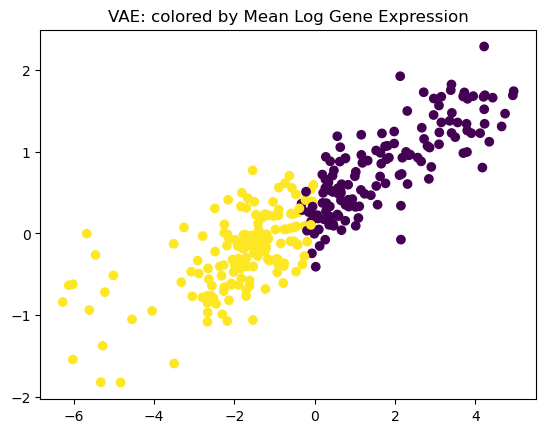

In [11]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=means)
plt.title('VAE: colored by Mean Log Gene Expression')
plt.show()

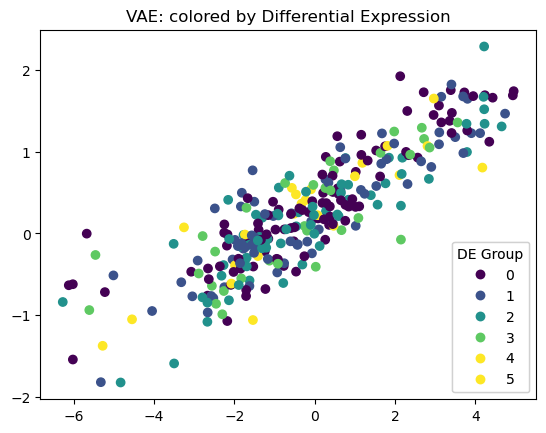

In [12]:
# create color map
cmap = plt.cm.get_cmap('viridis', 5)

# plot scatter plot with colored points
fig, ax = plt.subplots()
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=param, cmap=cmap)

# create legend
legend1 = ax.legend(*scatter.legend_elements(), loc='lower right', title="DE Group")
ax.add_artist(legend1)
plt.title('VAE: colored by Differential Expression')

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

Y = vae.predict(input_with_mask)

imputed = pd.DataFrame(Y)
scaler = StandardScaler()
z_scores = pd.DataFrame(scaler.fit_transform(imputed))
scaler2 = StandardScaler()
original2 = pd.DataFrame(scaler2.fit_transform(original.T))


# generate boolean mask for missing values
masked = df2.T.isnull()

# convert True values to index positions
missing_indexes = np.where(masked)

imputed_values = z_scores.iloc[missing_indexes].values.flatten()
orignal_values = original2.iloc[missing_indexes].values.flatten()

corr = np.corrcoef(orignal_values, imputed_values)[0, 1]
mse = np.mean((orignal_values - imputed_values) ** 2) / np.var(orignal_values)
print("Correlation coefficient:", corr)
print("Normalized Mean Squared Error:", mse)

In [ ]:
plt.scatter(imputed_values, orignal_values)
plt.plot([0, 5], [0, 5], color='red', linestyle='--')
plt.title('VAE')
plt.show()

# Scaled Data

In [ ]:
# Read the Data
#df = pd.read_csv('../../data/original.csv',  index_col=0)
scaled = pd.read_csv('../../data/mcar_scaled.csv',  index_col=0)
scaled = np.array(scaled)  
n_dims = scaled.shape[1]

In [ ]:
mask = np.array(bool_to_binary(create_missing_mask(scaled)))
X_no_na = replace_nan(scaled, replacement = 1)
scaled_with_mask = np.hstack([X_no_na, mask])


In [ ]:
vae.fit(scaled_with_mask,scaled_with_mask,
        epochs=500,
        batch_size=16)

In [ ]:
embedding = encoder.predict(input_with_mask)[0]
plt.scatter(embedding[:, 0], embedding[:, 1], c=y)
plt.show()